In [1]:
import pandas as pd
import numpy as np
import random as rnd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("questions.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
len(df)

404351

In [5]:
N_train = 300000
N_test = 10240
data_train = df[:N_train]
data_test = df[N_train:N_train + N_test]
print("Train set:", len(data_train), "Test set:", len(data_test))

Train set: 300000 Test set: 10240


In [8]:
data_train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [7]:
td_index = data_train['is_duplicate'] == 1
td_index = [i for i, x in enumerate(td_index) if x]
print('Number of duplicate questions: ', len(td_index))
print('Indexes of first ten duplicate questions:', td_index[:10])

Number of duplicate questions:  111486
Indexes of first ten duplicate questions: [5, 7, 11, 12, 13, 15, 16, 18, 20, 29]


In [9]:
print(data_train['question1'][5])
print(data_train['question2'][5])
print('is_duplicate: ', data_train['is_duplicate'][5])

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
is_duplicate:  1


In [10]:
Q1_train = np.array(data_train['question1'][td_index])
Q2_train = np.array(data_train['question2'][td_index])
Q1_test = np.array(data_test['question1'])
Q2_test = np.array(data_test['question2'])

In [11]:
y_test = np.array(data_test['is_duplicate'])

In [12]:
cut_off = int(len(Q1_train) * 0.8)
train_Q1, train_Q2 = Q1_train[:cut_off], Q2_train[:cut_off]
val_Q1, val_Q2 = Q1_train[cut_off:], Q2_train[cut_off:]
print('Number of duplicate questions: ', len(Q1_train))
print("The length of the training set is:  ", len(train_Q1))
print("The length of the validation set is: ", len(val_Q1))

Number of duplicate questions:  111486
The length of the training set is:   89188
The length of the validation set is:  22298


In [22]:
from posixpath import split
tf.random.set_seed(1)
text_vectorizer= tf.keras.layers.TextVectorization(
    output_mode='int',
    split='whitespace',
    ngrams=None,
    standardize = 'strip_punctuation',
)
text_vectorizer.adapt(np.concatenate([train_Q1, train_Q2]))

In [23]:
vocab = text_vectorizer.get_vocabulary()
print(len(vocab), vocab[:20])



32819 ['', '[UNK]', 'the', 'What', 'How', 'is', 'I', 'to', 'do', 'in', 'a', 'of', 'are', 'and', 'can', 'you', 'best', 'for', 'Why', 'my']


In [24]:
print('first question in the train set:\n')
print(Q1_train[0], '\n')
print('encoded version:')
print(text_vectorizer(Q1_train[0]),'\n')

print('first question in the test set:\n')
print(Q1_test[0], '\n')
print('encoded version:')
print(text_vectorizer(Q1_test[0]) )

first question in the train set:

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? 

encoded version:
tf.Tensor(
[ 6123     6   178    10  9079  2220 32055   788    13  6047 25433    30
    28   463    45    98], shape=(16,), dtype=int64) 

first question in the test set:

How do I prepare for interviews for cse? 

encoded version:
tf.Tensor([    4     8     6   157    17  1909    17 11616], shape=(8,), dtype=int64)


In [78]:
from os import name
def siamese_model(text_vectorizer, vocab_size = 32819, d_features = 128):

  branch = tf.keras.models.Sequential(name='sequential')
  branch.add(text_vectorizer)
  branch.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_features, name='embedding'))
  branch.add(tf.keras.layers.LSTM(d_features, return_sequences=True))
  branch.add(tf.keras.layers.GlobalAveragePooling1D(name='mean'))
  branch.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x))),

  input1 = tf.keras.Input(name='input_1', shape=(1,), dtype=tf.string)
  input2 = tf.keras.Input(name='input_2', shape=(1,), dtype=tf.string)


  branch1 = branch(input1)
  branch2 = branch(input2)

  merged = tf.keras.layers.concatenate([branch1, branch2], axis=-1, name='merged_layer')




  return tf.keras.models.Model(inputs=[input1, input2], outputs=merged, name='siamese_model')

In [65]:
help(tf.keras.models.Model)

Help on class Model in module keras.src.models.model:

class Model(keras.src.backend.tensorflow.trainer.TensorFlowTrainer, keras.src.trainers.trainer.Trainer, keras.src.layers.layer.Layer)
 |  Model(*args, **kwargs)
 |  
 |  A model grouping layers into an object with training/inference features.
 |  
 |  There are three ways to instantiate a `Model`:
 |  
 |  ## With the "Functional API"
 |  
 |  You start from `Input`,
 |  you chain layer calls to specify the model's forward pass,
 |  and finally, you create your model from inputs and outputs:
 |  
 |  ```python
 |  inputs = keras.Input(shape=(37,))
 |  x = keras.layers.Dense(32, activation="relu")(inputs)
 |  outputs = keras.layers.Dense(5, activation="softmax")(x)
 |  model = keras.Model(inputs=inputs, outputs=outputs)
 |  ```
 |  
 |  Note: Only dicts, lists, and tuples of input tensors are supported. Nested
 |  inputs are not supported (e.g. lists of list or dicts of dict).
 |  
 |  A new Functional API model can also be created 

In [79]:
model = siamese_model(text_vectorizer, vocab_size=text_vectorizer.vocabulary_size())
model.build(input_shape=None)
model.summary()
model.get_layer('sequential').summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_2 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128)            │      4,332,416 │ input_1[0][0],         │
│                           │                        │                │ input_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ merged_layer              │ (None, 256)            │              0 │ sequential[0][0],      │
│ (Concatenate)             │                        │                │ sequential[1][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,332,416 (16.53 MB)

 Trainable params: 4,332,416 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_2                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 128)           │       4,200,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, None, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mean (GlobalAveragePooling1D)        │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_9 (Lambda)                    │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,332,416 (16.53 MB)

 Trainable params: 4,332,416 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

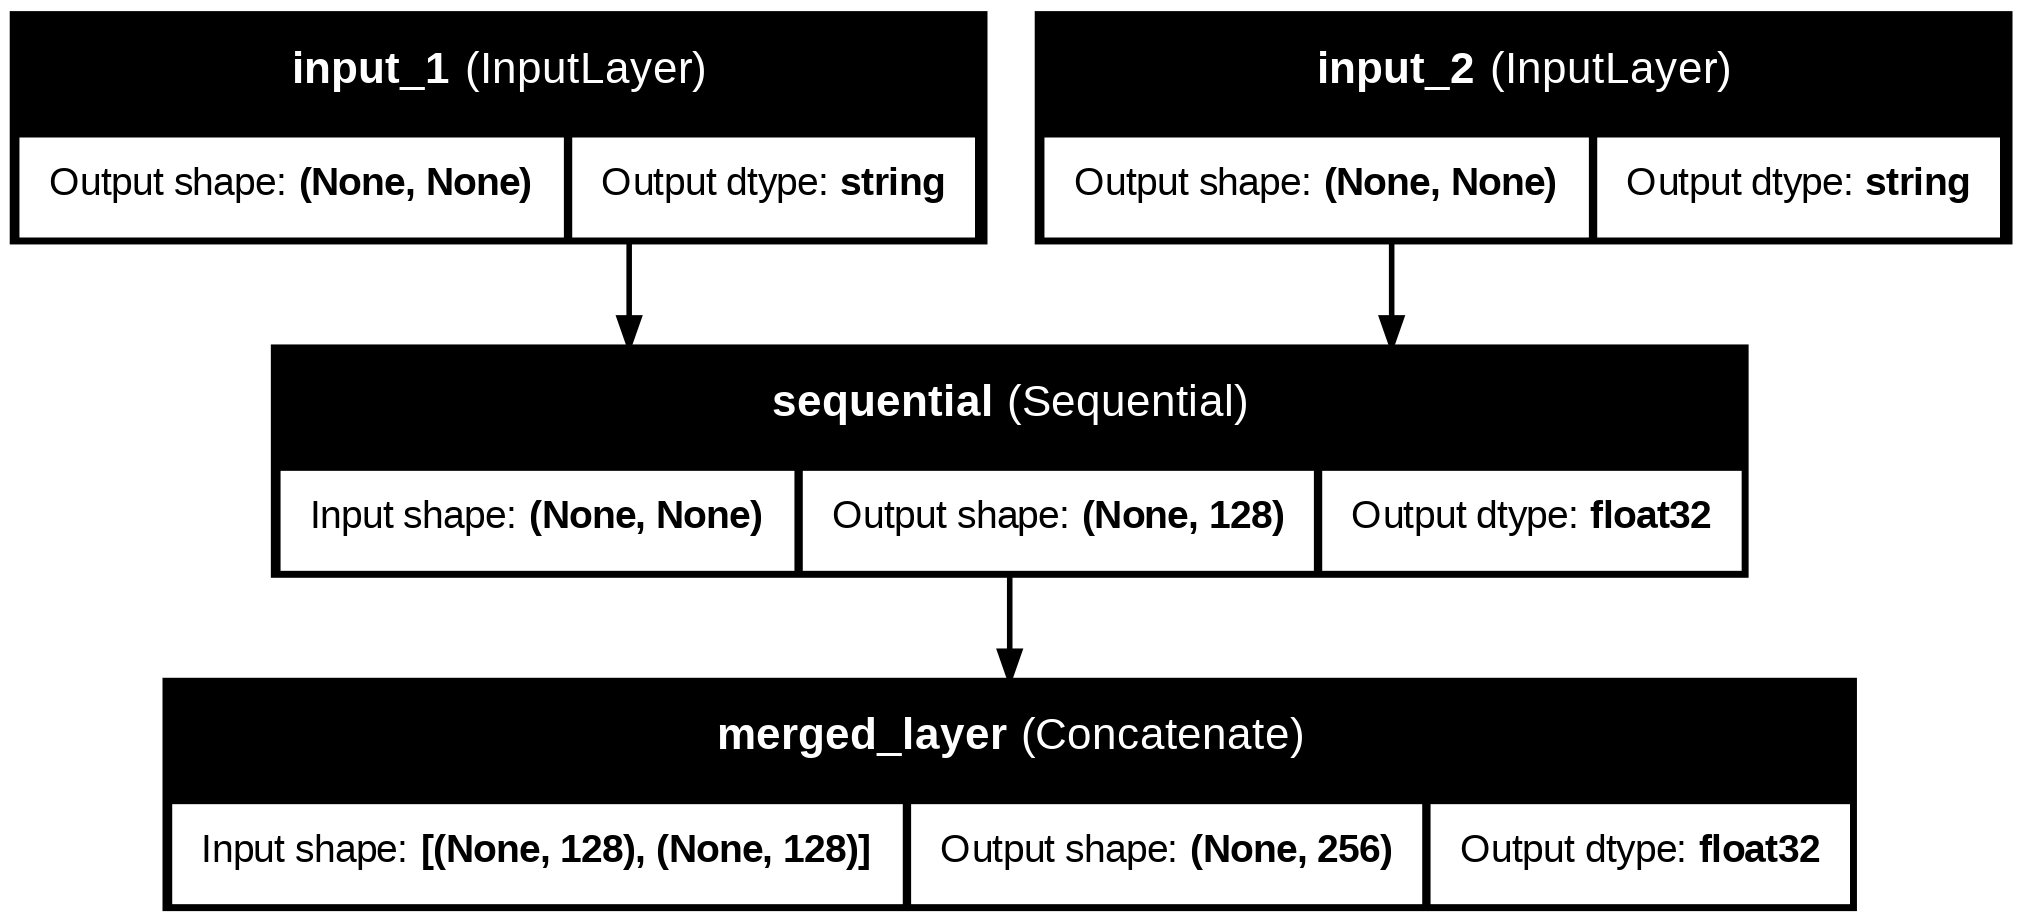

In [31]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True)

In [34]:
help(tf.transpose)

Help on function transpose_v2 in module tensorflow.python.ops.array_ops:

transpose_v2(a, perm=None, conjugate=False, name='transpose')
    Transposes `a`, where `a` is a Tensor.
    
    Permutes the dimensions according to the value of `perm`.
    
    The returned tensor's dimension `i` will correspond to the input dimension
    `perm[i]`. If `perm` is not given, it is set to (n-1...0), where n is the rank
    of the input tensor. Hence, by default, this operation performs a regular
    matrix transpose on 2-D input Tensors.
    
    If conjugate is `True` and `a.dtype` is either `complex64` or `complex128`
    then the values of `a` are conjugated and transposed.
    
    @compatibility(numpy)
    In `numpy` transposes are memory-efficient constant time operations as they
    simply return a new view of the same data with adjusted `strides`.
    
    TensorFlow does not support strides, so `transpose` returns a new tensor with
    the items permuted.
    @end_compatibility
    
   

In [48]:
def TripletLossFn(v1, v2,  margin=0.25):

    scores = tf.linalg.matmul(v2, v1, transpose_b=True)

    # calculate new batch size and cast it as the same datatype as scores.
    batch_size = tf.cast(tf.shape(v1)[0], scores.dtype)

    positive = tf.linalg.diag_part(scores)

    negative_zero_on_duplicate = scores - tf.linalg.diag(positive)

    mean_negative = tf.math.reduce_sum(negative_zero_on_duplicate, axis=1) / (batch_size - 1)

    mask_exclude_positives = tf.cast((tf.eye(tf.shape(v1)[0]) == 1) | (negative_zero_on_duplicate > tf.expand_dims(positive, 1)), scores.dtype)

    negative_without_positive = negative_zero_on_duplicate - (mask_exclude_positives * 2.0)

    # take the row by row `max` of `negative_without_positive`.
    closest_negative = tf.math.reduce_max(negative_without_positive, axis=1)

    # A = subtract `positive` from `margin` and add `closest_negative`
    triplet_loss1 = tf.maximum(0.0, margin - positive + closest_negative)
    triplet_loss2 = tf.maximum(0.0, margin - positive + mean_negative)
    triplet_loss = tf.math.reduce_sum(triplet_loss1 + triplet_loss2)


    return triplet_loss

In [49]:
v1 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
v2 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
print("Triplet Loss:", TripletLossFn(v1,v2).numpy())

Triplet Loss: 0.7035076825158911


In [50]:
def TripletLoss(labels, out, margin=0.25):
    _, embedding_size = out.shape # get embedding size
    v1 = out[:,:int(embedding_size/2)] # Extract v1 from out
    v2 = out[:,int(embedding_size/2):] # Extract v2 from out
    return TripletLossFn(v1, v2, margin=margin)

In [51]:
train_dataset = tf.data.Dataset.from_tensor_slices(((train_Q1, train_Q2),tf.constant([1]*len(train_Q1))))
val_dataset = tf.data.Dataset.from_tensor_slices(((val_Q1, val_Q2),tf.constant([1]*len(val_Q1))))

In [81]:
def train_model(Siamese, TripletLoss, text_vectorizer, train_dataset, val_dataset, d_feature=128, lr=0.01, train_steps=5):

    model = Siamese(text_vectorizer,
                    vocab_size = len(vocab), #set vocab_size accordingly to the size of your vocabulary
                    d_features = d_feature)

    model.compile(loss=TripletLoss,
                  optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
            )

    model.fit(train_dataset,
              epochs = train_steps,
              validation_data = val_dataset,
             )


    return model

In [59]:
len(vocab)

32819

In [82]:
batch_size = 256
train_generator = train_dataset.shuffle(len(train_Q1),
                                        seed=7,
                                        reshuffle_each_iteration=True).batch(batch_size=batch_size)
val_generator = val_dataset.shuffle(len(val_Q1),
                                   seed=7,
                                   reshuffle_each_iteration=True).batch(batch_size=batch_size)
model = train_model(siamese_model, TripletLoss,text_vectorizer,
                                            train_generator,
                                            val_generator,
                                            )

Epoch 1/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 173s 483ms/step - loss: 127.1997 - val_loss: 126.4804
Epoch 2/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 200s 477ms/step - loss: 126.5474 - val_loss: 126.3624
Epoch 3/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 166s 474ms/step - loss: 126.4448 - val_loss: 126.3198
Epoch 4/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 171s 490ms/step - loss: 126.4268 - val_loss: 126.3235
Epoch 5/5
349/349 ━━━━━━━━━━━━━━━━━━━━ 165s 470ms/step - loss: 126.4069 - val_loss: 126.2792


In [84]:
def classify(test_Q1, test_Q2, y_test, threshold, model, batch_size=64, verbose=True):

    y_pred = []
    test_gen = tf.data.Dataset.from_tensor_slices(((test_Q1, test_Q2),None)).batch(batch_size=batch_size)


    pred = model.predict(test_gen)
    _, n_feat = pred.shape
    v1 = pred[:, :int(n_feat / 2)]
    v2 = pred[:, int(n_feat / 2):]

    # Normalize v1 and v2 to get unit vectors for cosine similarity
    v1_norm = tf.linalg.l2_normalize(v1, axis=1)
    v2_norm = tf.linalg.l2_normalize(v2, axis=1)

    # Compute cosine similarity
    d = tf.reduce_sum(v1_norm * v2_norm, axis=1)

    # Check if d > threshold to make predictions
    y_pred = tf.cast(d > threshold, tf.float64)

    # Take the average of correct predictions to get the accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y_test), tf.float64))

    # Compute the confusion matrix using `tf.math.confusion_matrix`
    cm = tf.math.confusion_matrix(tf.cast(y_test, tf.int32), tf.cast(y_pred, tf.int32))

    ### END CODE HERE ###

    return accuracy, cm


In [85]:
accuracy, cm = classify(Q1_test,Q2_test, y_test, 0.7, model,  batch_size = 512)
print("Accuracy", accuracy.numpy())
print(f"Confusion matrix:\n{cm.numpy()}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/step
Accuracy 0.66357421875
Confusion matrix:
[[3968 2414]
 [1031 2827]]


In [88]:
def predict(question1, question2, threshold, model, verbose=False):

    generator = tf.data.Dataset.from_tensor_slices((([question1], [question2]),None)).batch(batch_size=1)

    ### START CODE HERE ###

    # Call the predict method of your model and save the output into v1v2
    v1v2 = model.predict(generator)
    embedding_size = v1v2.shape[1] // 2  # Divide by 2 as it contains both embeddings

    # Extract v1 and v2 from the model output
    v1 = v1v2[:, :embedding_size]  # First half of the embedding
    v2 = v1v2[:, embedding_size:]
    # Take the dot product to compute cos similarity of each pair of entries, v1, v2
    # Since v1 and v2 are both vectors, use the function tf.math.reduce_sum instead of tf.linalg.matmul
    d = tf.math.reduce_sum(v1 * v2, axis=1)
    # Is d greater than the threshold?
    res = tf.cast(d > threshold, tf.float64)

    ### END CODE HERE ###

    if(verbose):
        print("Q1  = ", question1, "\nQ2  = ", question2)
        print("d   = ", d.numpy())
        print("res = ", res.numpy())

    return res.numpy()

In [89]:
question1 = "When will I see you?"
question2 = "When can I see you again?"
# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, verbose = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Q1  =  When will I see you? 
Q2  =  When can I see you again?
d   =  [0.98898417]
res =  [1.]


array([1.])

In [90]:
question1 = "Do they enjoy eating the dessert?"
question2 = "Do they like hiking in the desert?"
# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Q1  =  Do they enjoy eating the dessert? 
Q2  =  Do they like hiking in the desert?
d   =  [-0.00178196]
res =  [0.]


array([0.])